In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.channels.aoyama00 import Leak, Na, Kdr, Kto, Kar, Ca
from jaxley_mech.utils import prettify

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [2]:
META = {
    "cell_type": "Horizontal cell",
    "species": "Rabbit",
    "reference": [
        "Aoyama, T., Kamiyama, Y., Usui, S., Blanco, R., Vaquero, C. F., & De La Villa, P. (2000). Ionic current model of rabbit retinal horizontal cell. Neuroscience Research, 37(2), 141–151. https://doi.org/10.1016/S0168-0102(00)00111-5",
    ],
}

### Figure 3

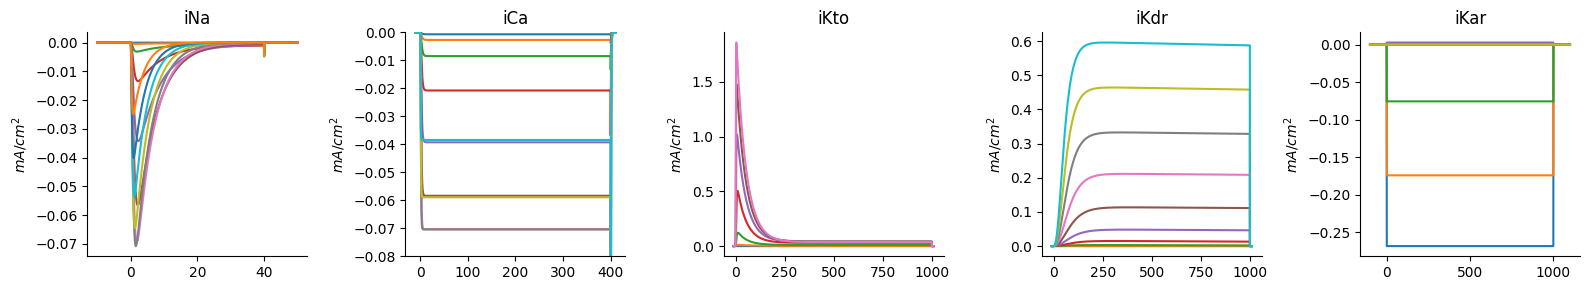

In [3]:
to_records = ["iNa", "iCa", "iKto", "iKdr", "iKar"]
mosaic = [["iNa", "iCa", "iKto", "iKdr", "iKar"]]

params = {
    "length": 10,
    "radius": 5,
    "v": -80,
    "capacitance": 1,
    "axial_resistivity": 160,
}

fig, ax = plt.subplot_mosaic(mosaic, figsize=(16, 3))

# Na (shorter)
for v_step in jnp.arange(-70, 41, 10):
    to_records = ["iNa"]

    cell = Compartment()
    cell.insert(Na())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 500  # ms
    vc_on_time = 40  # ms
    total_time = 600 # ms
    dt = 0.01 # ms, 
    time_steps = int(total_time // dt + 1)

    v = jnp.zeros(time_steps) - 80. # hold at -80 mV
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(10/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)
    for i, rec in enumerate(to_records):
        if rec == "iNa":
            ax[rec].plot(s["time"][vc_on-padding:vc_off+padding]-pre_vc_time, s[rec][vc_on-padding:vc_off+padding])

        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        ax[rec].set_ylabel(r"$mA/cm^2$")

# Ca (shorter)
for v_step in jnp.arange(-50, 50, 10):
    to_records = ["iCa"]

    cell = Compartment()
    cell.insert(Ca())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.set("Ca_gCa", 3.3e-3) # 9 nS in the paper; 
            # has to be scaled down to match the amplitude in the paper

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 500  # ms
    vc_on_time = 400  # ms
    total_time = 1000 # ms
    dt = 0.01 # ms
    time_steps = int(total_time // dt + 1)

    v = jnp.zeros(time_steps) - 80. # hold at -80 mV
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(10/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)
    for i, rec in enumerate(to_records):
        if rec == "iCa":
            ax[rec].plot(s["time"][vc_on-padding:vc_off+padding]-pre_vc_time, s[rec][vc_on-padding:vc_off+padding])

        ax[rec].set_title(rec)
        ax[rec].set_ylim(-0.08, 0)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        ax[rec].set_ylabel(r"$mA/cm^2$")

# Kto (shorter)
# Kdr and Kto
for v_step in jnp.arange(-70, 110+1, 10):
    to_records = ["iKdr", "iKto"]

    cell = Compartment()
    cell.insert(Kdr())
    cell.insert(Kto())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 1000  # ms
    vc_on_time = 1000  # ms
    total_time = 2500 # ms
    dt = 0.01 # ms, 
    time_steps = int(total_time // dt + 1)

    v = jnp.zeros(time_steps) - 80.  # hold at -80 mV
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(10/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)
    for i, rec in enumerate(to_records):

        if rec == "iKar":
            continue    
        elif rec == "iNa":
            continue
        elif rec == "iCa":
            continue
        elif rec == "iKto" and v_step not in jnp.arange(-60, 61, 20):
            continue
        elif rec == "iKdr" and v_step not in jnp.arange(-70, 111, 20):
            continue
            
        ax[rec].plot(s["time"][vc_on-padding:vc_off+padding]-pre_vc_time, s[rec][vc_on-padding:vc_off+padding])
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        ax[rec].set_ylabel(r"$mA/cm^2$")
        
# Kar   
params = {
    "length": 10,
    "radius": 5,
    "v": -40,
    "capacitance": 1,
    "axial_resistivity": 160,
}

for v_step in jnp.arange(-140, 21, 20):
    to_records = ["iKar"]

    cell = Compartment()
    cell.insert(Kar())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 1000  # ms
    vc_on_time = 1000  # ms
    total_time = 2500 # ms
    dt = 0.01 # ms, 
    time_steps = int(total_time // dt + 1)

    v = jnp.zeros(time_steps) - 40.
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(100/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)
    for i, rec in enumerate(to_records):            
        if rec == "iKar" and v_step in jnp.arange(-140, 21, 20):
            ax[rec].plot(s["time"][vc_on-padding:vc_off+padding]-pre_vc_time, s[rec][vc_on-padding:vc_off+padding])
            ax[rec].set_title(rec)
            ax[rec].spines["top"].set_visible(False)
            ax[rec].spines["right"].set_visible(False)
            ax[rec].set_ylabel(r"$mA/cm^2$")
        else:
            continue

fig.tight_layout()

In [4]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-02-21 09:37:37CET

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.32.0

jaxley     : 0.6.2
jax        : 0.4.31
matplotlib : 3.10.0
jaxley_mech: 0.3.0

Watermark: 2.5.0

